# Введение в нейронные сети

## Урок 5. Рекуррентные нейронные сети

Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
#!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

In [4]:
airline_passengers_data = pd.read_csv('./data/airline-passengers.csv')

In [5]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [8]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [9]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [10]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [11]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [12]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [13]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [14]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [15]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [16]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

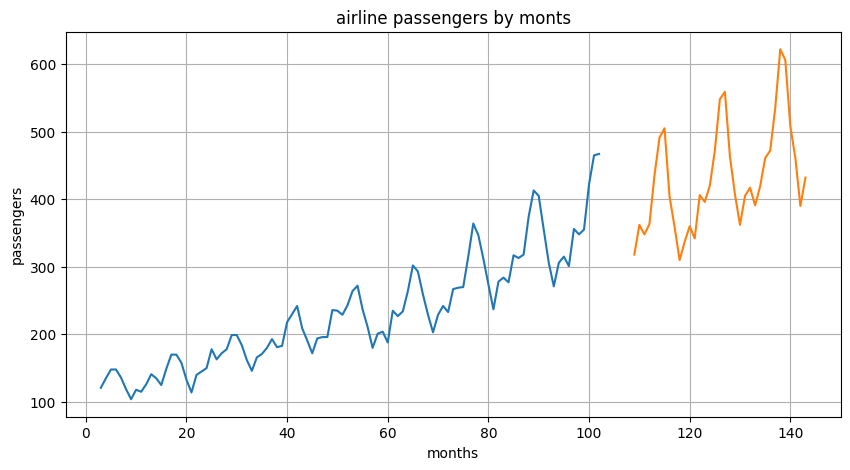

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [19]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [20]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [21]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [22]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [23]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 27ms/step - loss: 57545.9609 - mae: 226.6782 - val_loss: 198842.6250 - val_mae: 438.6254
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 56448.5117 - mae: 224.4319 - val_loss: 194738.0781 - val_mae: 434.0282
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 56053.3281 - mae: 224.1584 - val_loss: 191347.4844 - val_mae: 430.2108
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 55448.4805 - mae: 223.4163 - val_loss: 186595.2188 - val_mae: 424.8145
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 54127.3125 - mae: 221.4642 - val_loss: 177138.0625 - val_mae: 413.8445
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 50914.9180 - mae: 216.1801 - val_loss: 156505.4844 - val_mae: 388.7059
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 43255.4141 - mae: 201.5529 - val_loss: 114917.5156 - val_mae: 331.917

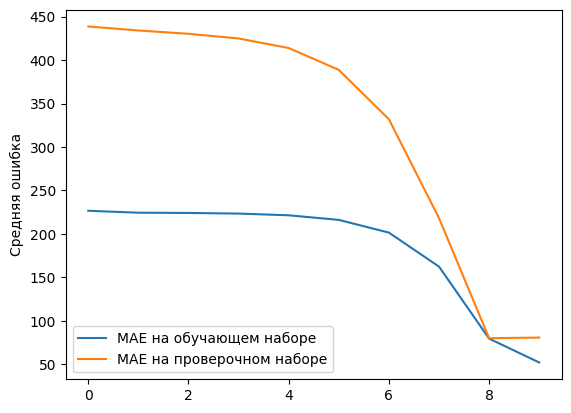

In [24]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [25]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [26]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 1417.5941 - mae: 27.4083 - val_loss: 16895.2266 - val_mae: 106.5847
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 1080.7844 - mae: 25.3105 - val_loss: 10868.3359 - val_mae: 80.5899
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 1191.0282 - mae: 27.6389 - val_loss: 10662.1641 - val_mae: 80.4719
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 1096.8613 - mae: 26.3607 - val_loss: 11368.5059 - val_mae: 84.5765
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 1043.8582 - mae: 25.6667 - val_loss: 10585.5938 - val_mae: 80.5770
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 1006.1982 - mae: 25.1349 - val_loss: 10297.6035 - val_mae: 79.2578
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 966.5499 - mae: 24.6661 - val_loss: 10012.0537 - val_mae: 78.0085
Epoch 8/10
13/13 [=========

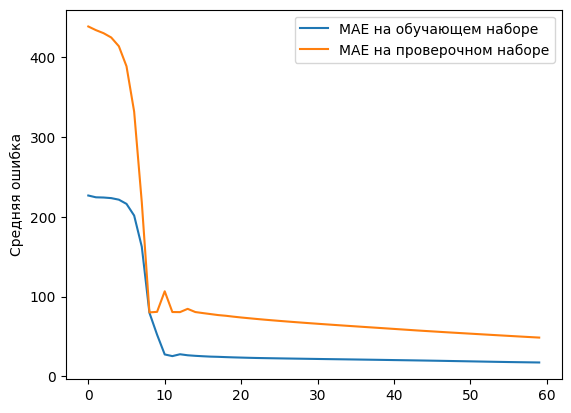

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 479.4402 - mae: 17.1958 - val_loss: 4368.1523 - val_mae: 48.0498
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 473.2681 - mae: 17.0623 - val_loss: 4303.9126 - val_mae: 47.5640
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 467.2009 - mae: 16.9315 - val_loss: 4241.4551 - val_mae: 47.1350
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 461.1785 - mae: 16.7998 - val_loss: 4180.5562 - val_mae: 46.7116
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 455.1396 - mae: 16.6668 - val_loss: 4120.9951 - val_mae: 46.2899
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 449.0194 - mae: 16.5308 - val_loss: 4062.5222 - val_mae: 45.8793
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 442.7540 - mae: 16.3930 - val_loss: 4004.8850 - val_mae: 45.5105
Epoch 8/10
13/13 [=======================

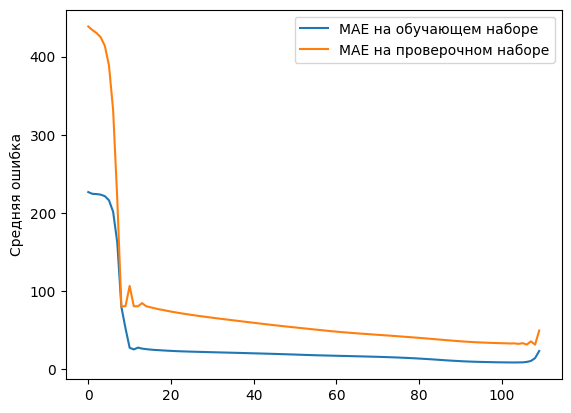

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 1996.4454 - mae: 30.7207 - val_loss: 1732.8324 - val_mae: 34.7545
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 3124.2788 - mae: 41.8591 - val_loss: 3196.9668 - val_mae: 41.1409
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 1296.5271 - mae: 30.0073 - val_loss: 3629.7551 - val_mae: 44.8006
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 642.9199 - mae: 19.3151 - val_loss: 2202.7759 - val_mae: 33.2919
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 916.0623 - mae: 27.2599 - val_loss: 2618.1006 - val_mae: 36.8520
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 724.2952 - mae: 24.7098 - val_loss: 2904.1655 - val_mae: 39.5155
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 458.4767 - mae: 18.8031 - val_loss: 2190.4741 - val_mae: 33.8557
Epoch 8/10
13/13 [===================

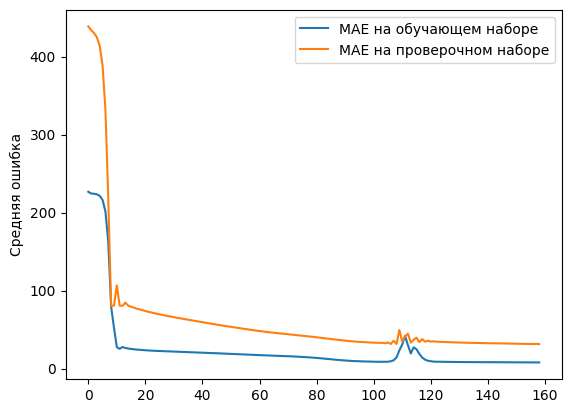

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 100.1310 - mae: 7.7339 - val_loss: 1851.1122 - val_mae: 31.4360
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 98.9177 - mae: 7.7797 - val_loss: 1820.3729 - val_mae: 31.3826
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 99.7233 - mae: 7.7222 - val_loss: 1782.4415 - val_mae: 31.0313
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 101.0426 - mae: 7.8074 - val_loss: 1853.5337 - val_mae: 31.5205
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 102.1993 - mae: 8.0203 - val_loss: 1730.7899 - val_mae: 30.8499
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 101.3145 - mae: 7.6958 - val_loss: 1829.9310 - val_mae: 31.2408
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 98.4791 - mae: 7.7365 - val_loss: 1767.8169 - val_mae: 31.2221
Epoch 8/10
13/13 [==============================] -

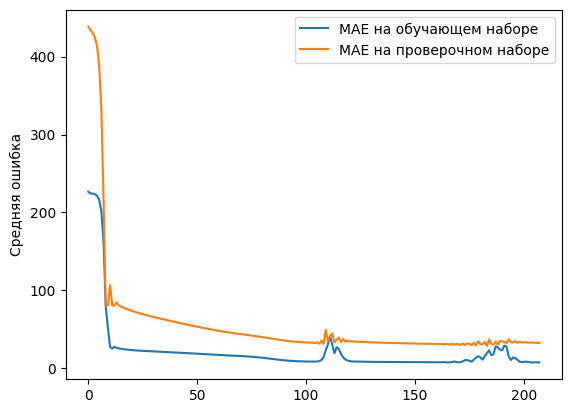

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 93.3560 - mae: 7.5500 - val_loss: 2036.4110 - val_mae: 32.5206
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 94.8616 - mae: 7.4979 - val_loss: 2030.1666 - val_mae: 32.4391
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 95.6022 - mae: 7.5359 - val_loss: 2015.2825 - val_mae: 32.3752
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 94.4856 - mae: 7.6319 - val_loss: 1997.5284 - val_mae: 32.2100
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 93.3394 - mae: 7.3660 - val_loss: 2000.7853 - val_mae: 32.2045
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 92.0993 - mae: 7.4285 - val_loss: 1977.7653 - val_mae: 32.1135
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 94.2351 - mae: 7.5286 - val_loss: 1964.0571 - val_mae: 31.9331
Epoch 8/10
13/13 [==============================] - 0s 

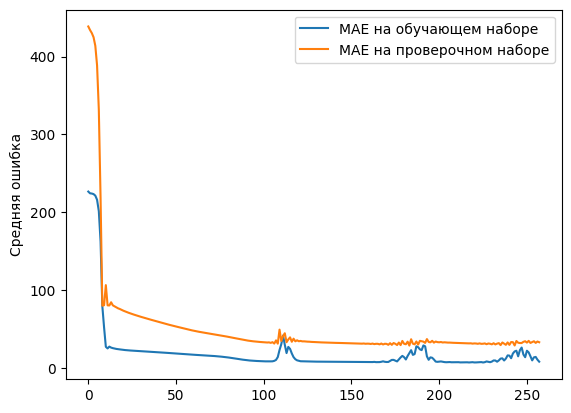

In [27]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [28]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


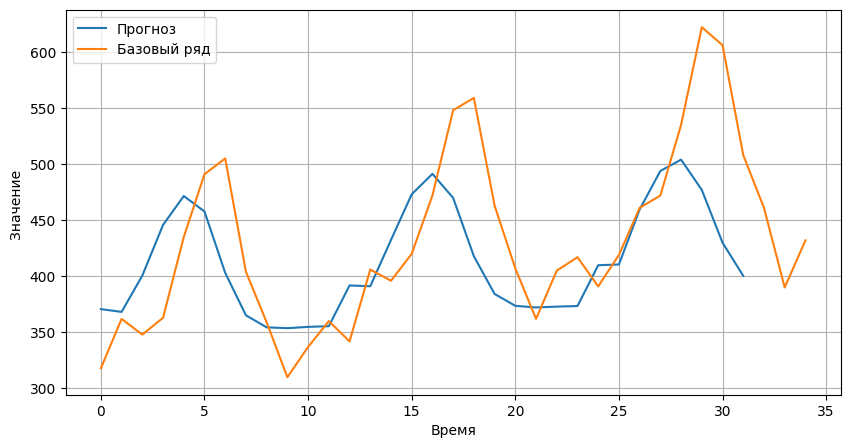

In [29]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

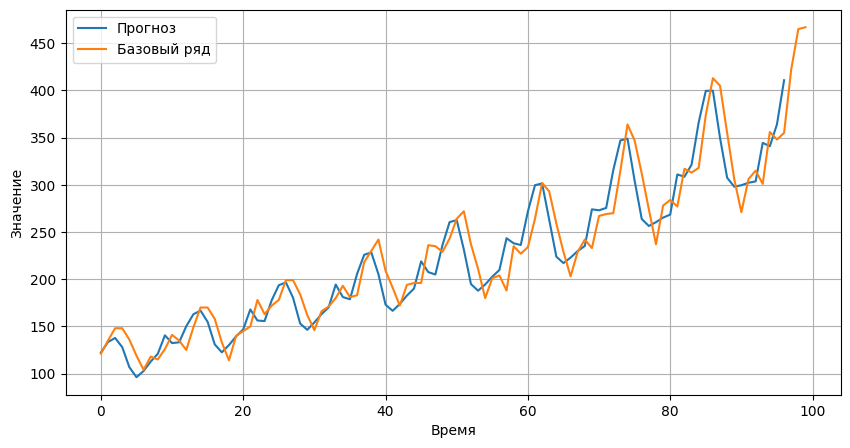

In [30]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [31]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 2ms/step - loss: 2113.8167 - mae: 33.2509
train_loss: 107.18090057373047, train_m: 8.433602333068848
test_loss: 2113.816650390625, test_m: 33.250850677490234


**LSTM**

In [32]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [33]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 5s 73ms/step - loss: 56617.3281 - mae: 225.5521 - val_loss: 192998.0156 - val_mae: 431.9878
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 56101.2148 - mae: 224.4559 - val_loss: 191471.0938 - val_mae: 430.2265
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 54599.6641 - mae: 221.3882 - val_loss: 186259.6719 - val_mae: 424.1794
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 49631.2383 - mae: 210.9982 - val_loss: 168246.0938 - val_mae: 402.6549
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 34830.5625 - mae: 176.5413 - val_loss: 113868.3125 - val_mae: 329.4643
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 7198.6108 - mae: 75.8239 - val_loss: 21350.9922 - val_mae: 131.6807
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 5947.1299 - mae: 61.7272 - val_loss: 7662.6553 - val_mae: 69.2640
Epoc

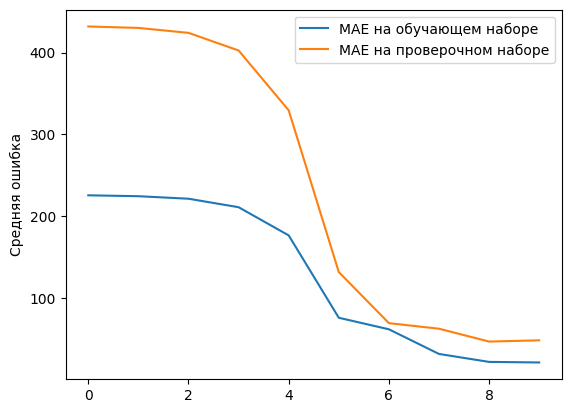

In [34]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [35]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [36]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 710.2565 - mae: 20.6527 - val_loss: 4417.7124 - val_mae: 48.2948
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 696.3539 - mae: 20.4026 - val_loss: 4195.3984 - val_mae: 47.2559
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 683.4418 - mae: 20.0794 - val_loss: 4255.1177 - val_mae: 47.3207
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 678.7661 - mae: 20.0564 - val_loss: 4127.3916 - val_mae: 46.7785
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 673.2856 - mae: 19.9536 - val_loss: 4088.3694 - val_mae: 46.5764
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 668.5871 - mae: 19.9009 - val_loss: 4014.6917 - val_mae: 46.2334
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 664.2542 - mae: 19.8508 - val_loss: 3961.2998 - val_mae: 45.9630
Epoch 8/10
13/13 [====================

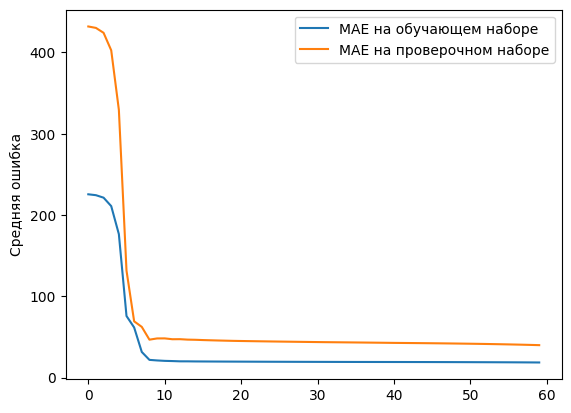

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 548.3173 - mae: 18.5953 - val_loss: 2744.6306 - val_mae: 39.7062
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 542.7593 - mae: 18.5159 - val_loss: 2706.9893 - val_mae: 39.4084
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 536.6778 - mae: 18.4251 - val_loss: 2667.4207 - val_mae: 39.0868
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 530.0214 - mae: 18.3216 - val_loss: 2625.7839 - val_mae: 38.7776
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 522.7388 - mae: 18.2039 - val_loss: 2581.9460 - val_mae: 38.4563
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 514.7795 - mae: 18.0707 - val_loss: 2535.7932 - val_mae: 38.1063
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 506.0973 - mae: 17.9204 - val_loss: 2487.2263 - val_mae: 37.7257
Epoch 8/10
13/13 [===================

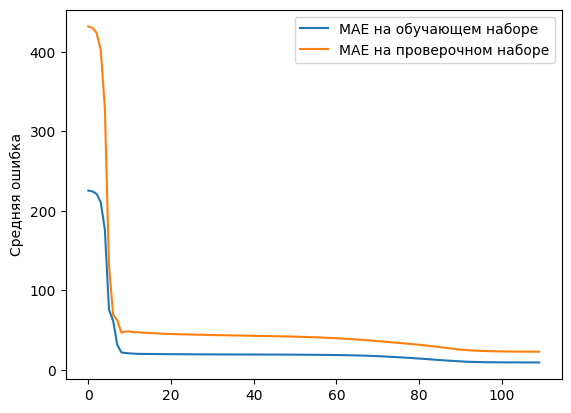

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 137.9937 - mae: 9.2248 - val_loss: 741.7772 - val_mae: 22.8227
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 137.6749 - mae: 9.2135 - val_loss: 741.4064 - val_mae: 22.8238
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 137.3705 - mae: 9.2027 - val_loss: 741.3321 - val_mae: 22.8266
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 137.0770 - mae: 9.1932 - val_loss: 741.5394 - val_mae: 22.8313
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 136.7964 - mae: 9.1850 - val_loss: 741.9734 - val_mae: 22.8410
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 136.5276 - mae: 9.1766 - val_loss: 742.5986 - val_mae: 22.8617
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 136.2669 - mae: 9.1681 - val_loss: 743.4301 - val_mae: 22.8837
Epoch 2/10
13/13 [==============================] - 

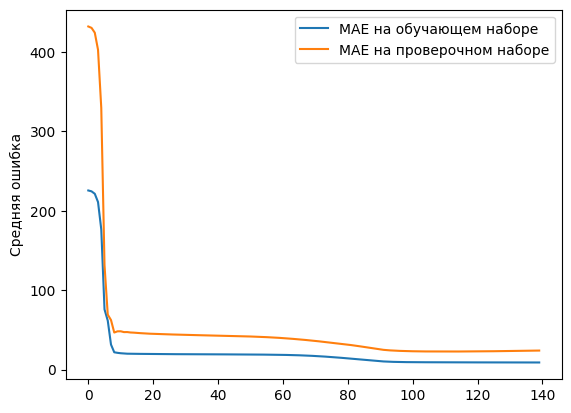

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 131.9983 - mae: 9.0219 - val_loss: 797.9746 - val_mae: 24.0904
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 131.8737 - mae: 9.0170 - val_loss: 801.2489 - val_mae: 24.1541
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 131.7543 - mae: 9.0121 - val_loss: 804.5454 - val_mae: 24.2172
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 131.6398 - mae: 9.0072 - val_loss: 807.8323 - val_mae: 24.2789
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 131.5248 - mae: 9.0023 - val_loss: 811.2048 - val_mae: 24.3410
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 131.4092 - mae: 8.9978 - val_loss: 814.7153 - val_mae: 24.4043
Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 131.2983 - mae: 8.9934 - val_loss: 818.2648 - val_mae: 24.4674
Epoch 2/10
13/13 [==============================] - 0

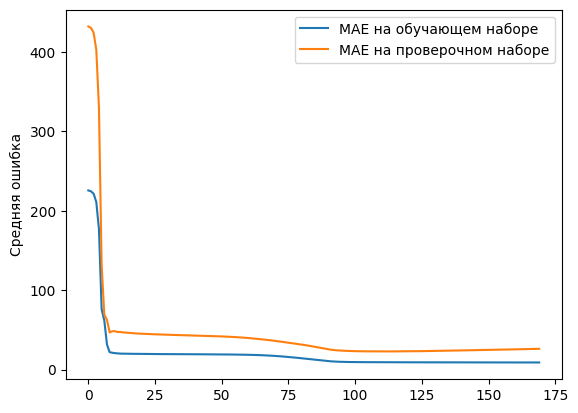

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 129.1490 - mae: 8.9013 - val_loss: 915.8331 - val_mae: 26.1600
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 129.1808 - mae: 8.8910 - val_loss: 916.4862 - val_mae: 26.1676
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 129.0195 - mae: 8.8911 - val_loss: 921.2452 - val_mae: 26.2369
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 128.7400 - mae: 8.8996 - val_loss: 931.5771 - val_mae: 26.3922
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 128.6439 - mae: 8.8989 - val_loss: 939.9050 - val_mae: 26.5174
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 128.8436 - mae: 8.8801 - val_loss: 938.7538 - val_mae: 26.4990
Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 129.0222 - mae: 8.8619 - val_loss: 934.0751 - val_mae: 26.4244
Epoch 2/10
13/13 [==============================] - 

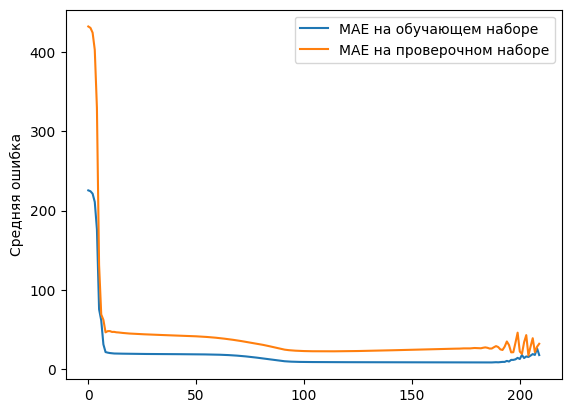

In [37]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [38]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


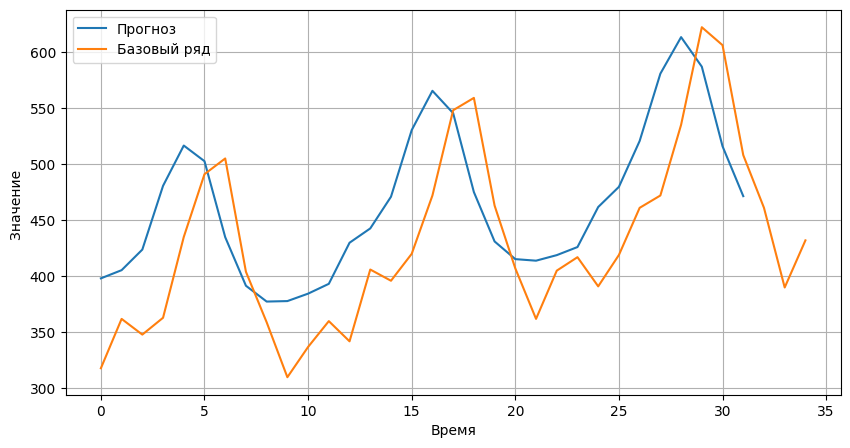

In [39]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

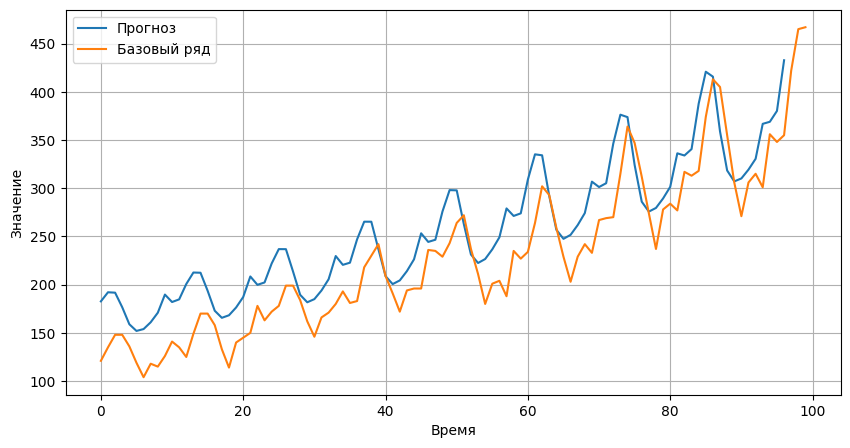

In [40]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 2ms/step - loss: 1384.4818 - mae: 32.3121
train_loss: 1098.7855224609375, train_m: 30.37664222717285
test_loss: 1384.4818115234375, test_m: 32.312103271484375


**Выводы: **<br>
* чем больше итераций - тем выше качество (25 и правда хватает)